# Домашнее задание №2 - Линейные модели. Градиентный спуск

В этом домашнем задании мы с вами научимся обучать линейные модели регрессии и классификации при помощи очень мощного, но в то же время довольно понятного алгоритма, который называется **градиетный спуск**. Помимо линейных моделей он используется и для обучения самых сложных нейронных сетей! Также мы потренируемся применять готовые реализации линейных моделей для задач регрессии и бинарной классификации.

In [1723]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error,roc_auc_score)
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.compose  import ColumnTransformer

In [1724]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда графиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [1725]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

Обратите внимание, что $x$ - numpy-array вектор длины 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуйте функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [1726]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    
    return 2*np.sin(w)*np.cos(w)

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [1727]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [1728]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентного спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= grad_f(curr_w) * lr #  YOUR CODE. Не забудьте про lr!
    
    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [1729]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

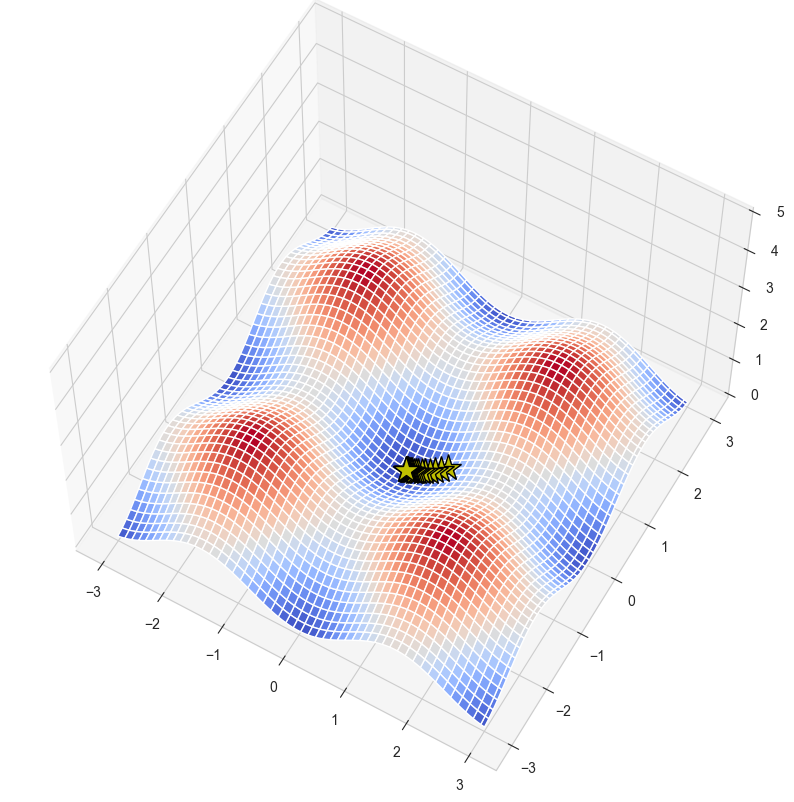

In [1730]:
steps = gradient_desc_vis(f, grad_f)

Посмотрим на зависимость значения функции от шага градиентного спуска.

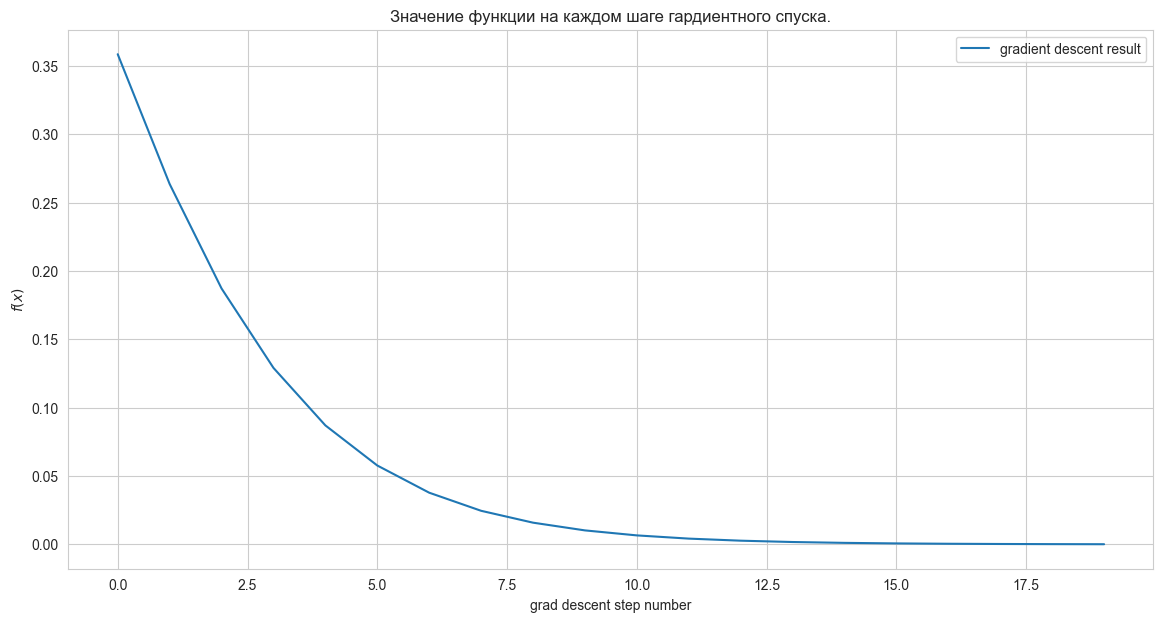

In [1731]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге гардиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

### Задание 2. Реализация линейной регресии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной часть является реализация функции потерь и функции для расчета ее градиента. Перем началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

#### Задание 2.1. MSE и ее градиент (2 балла)

In [1732]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return ((y_true - y_pred)**2).mean()
    

def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return 2 * (X.T @ (y_pred - y_true)) / np.size(y_pred)


class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [1733]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

В данном задании нужно будет реализовать линейную регрессию и обучить ее при помощи градиентного спуска. Для этого нужно будет заполнять пропуски кода в соответствующих классах. Для начала мы реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий. Не переживайте, этот класс уже реализован, вам достостаточно просто разобраться с кодом.

In [1734]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуйте метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [1735]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        y_pred = np.matmul(X_test, self.W)
        return y_pred
    
    
    def __repr__(self):
        return "My custom linear regression"

##### Проверим нашу реализацию на простом примере

In [1736]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

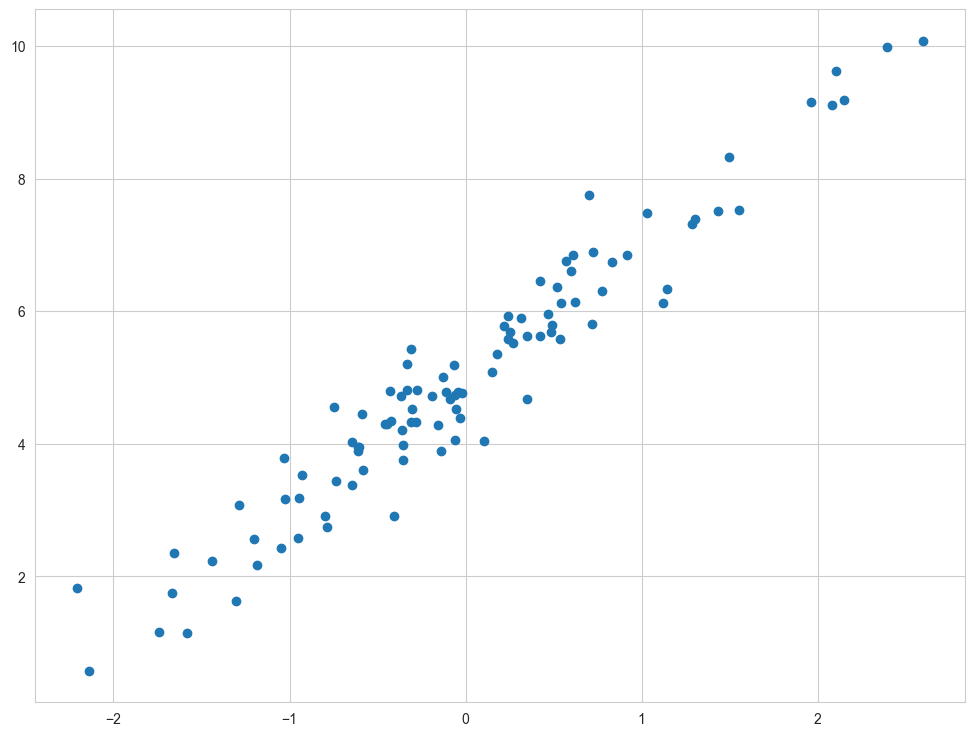

In [1737]:
plt.scatter(X, y);

In [1738]:
custom_lin_reg = CustomLinearRegression()

In [1739]:
custom_lin_reg.fit(X, y)

My custom linear regression

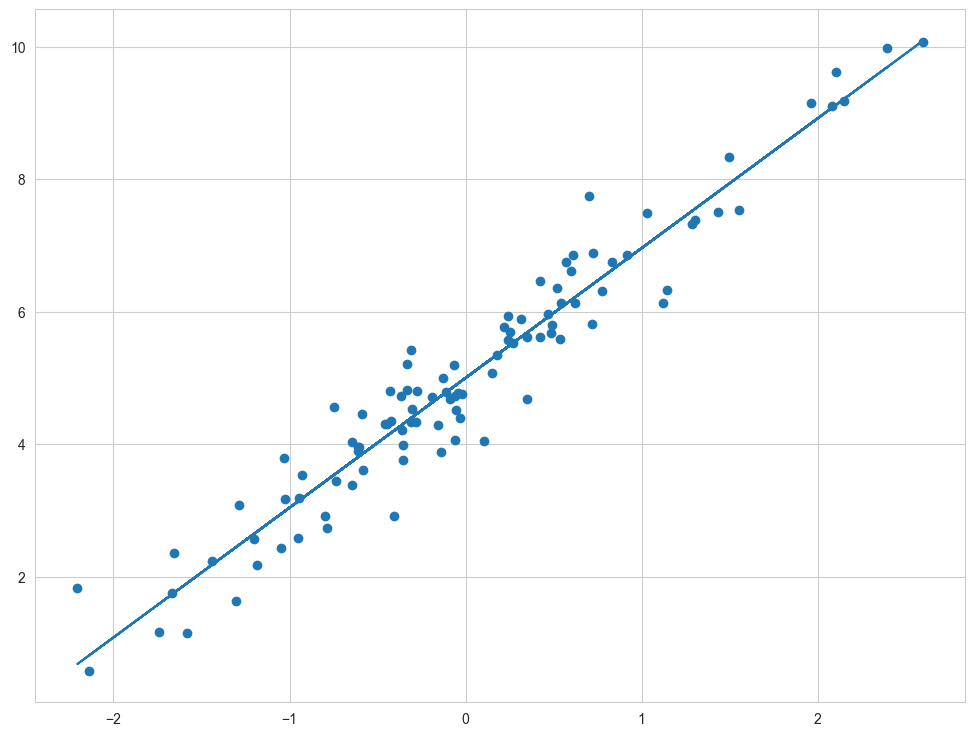

In [1740]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X));

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Калифорнии. Постройте модель линейной регресии при помощи `LinearRegression` из `sklearn`. Не забудьте разделить данные на тренировочную и тестовую части, а также правильно предобработать признаки. В конце воспользуйтесь какими-то изученными метриками регресии и сделайте выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [1741]:
data = fetch_california_housing()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

Ваш ход:

In [1742]:
#Для удобства переведем данные в Датафрейм
X = pd.DataFrame(data=X, columns=feature_names)
#Посмотрим на них
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [1743]:
#Проверим тип данных во всех столбцах
X.info()
#Все колонки имеют тип данных float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [1744]:
#Проверим данные на наличие пропусков
X.isna().sum() / len(X)

MedInc        0.0
HouseAge      0.0
AveRooms      0.0
AveBedrms     0.0
Population    0.0
AveOccup      0.0
Latitude      0.0
Longitude     0.0
dtype: float64

In [1745]:
print(f"Общее количество наблюдений: {len(X)}")

Общее количество наблюдений: 20640


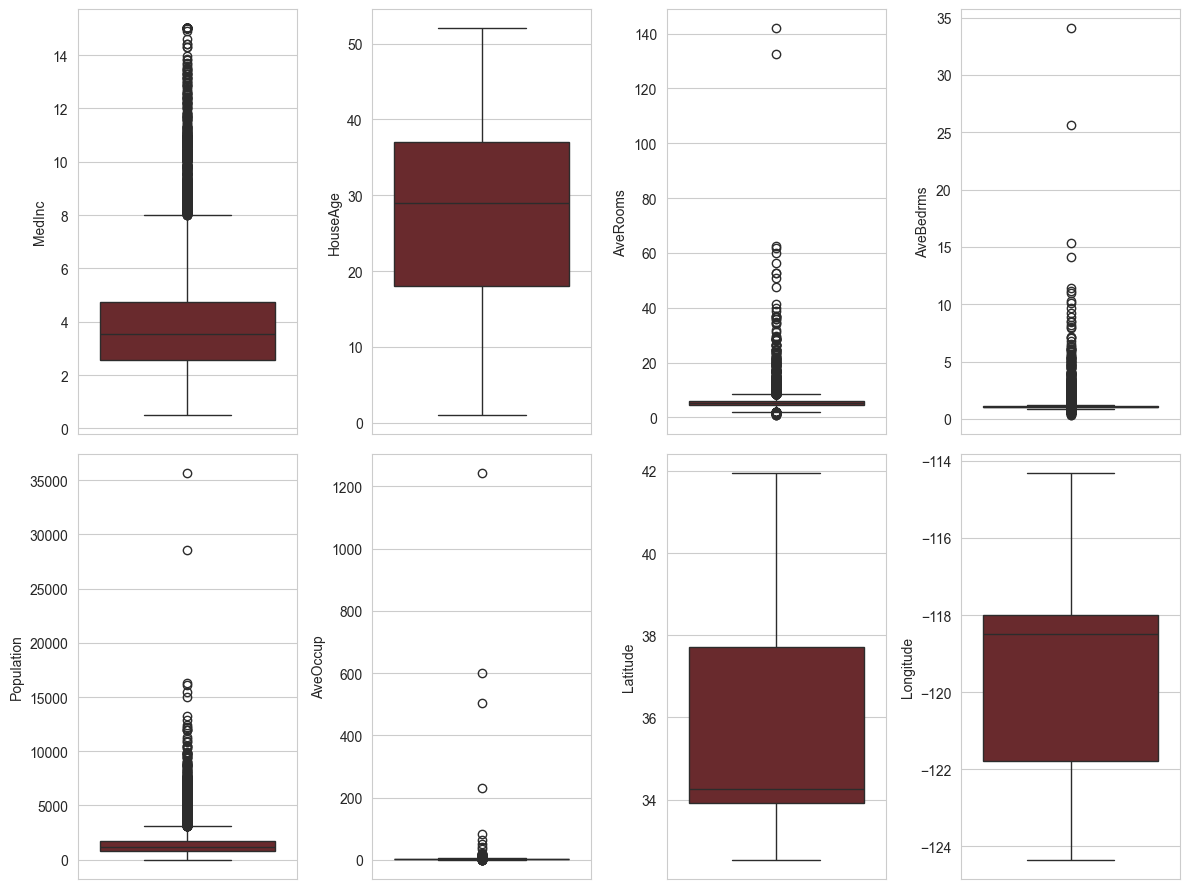

In [1746]:
#Посмотрим на распределение данных
i = 1
for col in X.columns[:]:
  plt.subplot(2, 4, i)
  sns.boxplot(X[col], color = '#732023')
  i += 1

plt.tight_layout();

median_income: Средний доход в пределах квартала домов 
house_age: Cредний возраст дома в квартале; меньшее число указывает на более новое здание
ave_rooms: Количество комнат
avebedrms: Количество спален
population: Black население
ave_occup: Вместимость дома
longitude: Долгота жилого дома
latitude: Широта жилого дома


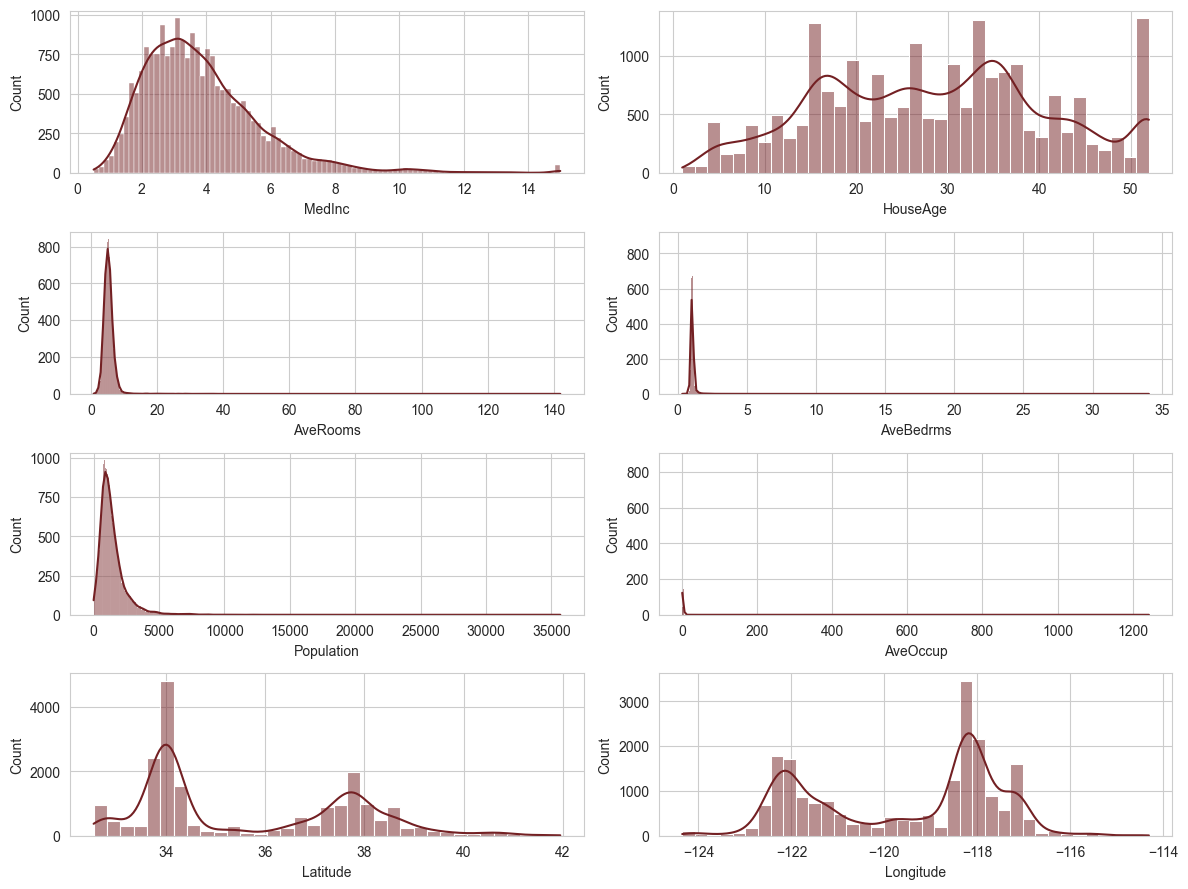

In [1747]:
import scipy.stats as stats 
#Посмотрим на распределение переменных
i = 1
for col in X.columns[:]:
  plt.subplot(4, 2, i)
  sns.histplot(X[col], color = '#732023',kde=True)
  i += 1

plt.tight_layout();

#По графикам видно, что данные не имеют нормального распределения

In [1748]:
#Проверим это также с использованием теста Шапиро-Уилка
for col in X.columns:
  print(f"{col} - {stats.shapiro(X[col])}")
# p-value везде меньше 0.01, поэтому на уровне значимости 1% 
# гипотеза о нормальности отвергается для всех колонок

MedInc - ShapiroResult(statistic=0.8932307509080386, pvalue=6.560004141576977e-79)
HouseAge - ShapiroResult(statistic=0.9782468190531594, pvalue=1.5602225615811627e-47)
AveRooms - ShapiroResult(statistic=0.425701233373074, pvalue=5.987884604017143e-121)
AveBedrms - ShapiroResult(statistic=0.16039246232650284, pvalue=1.0642657909746482e-131)
Population - ShapiroResult(statistic=0.7133165954100374, pvalue=1.7444774799024147e-102)
AveOccup - ShapiroResult(statistic=0.015914747342511415, pvalue=2.4830289331797888e-136)
Latitude - ShapiroResult(statistic=0.87711326686798, pvalue=4.4951610612854584e-82)
Longitude - ShapiroResult(statistic=0.896997471539459, pvalue=4.1213064328225716e-78)


/var/folders/7w/bn4plfg54bxf7fbpr3dxlsxc0000gn/T/ipykernel_50475/2876001223.py:3: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20640.
  print(f"{col} - {stats.shapiro(X[col])}")


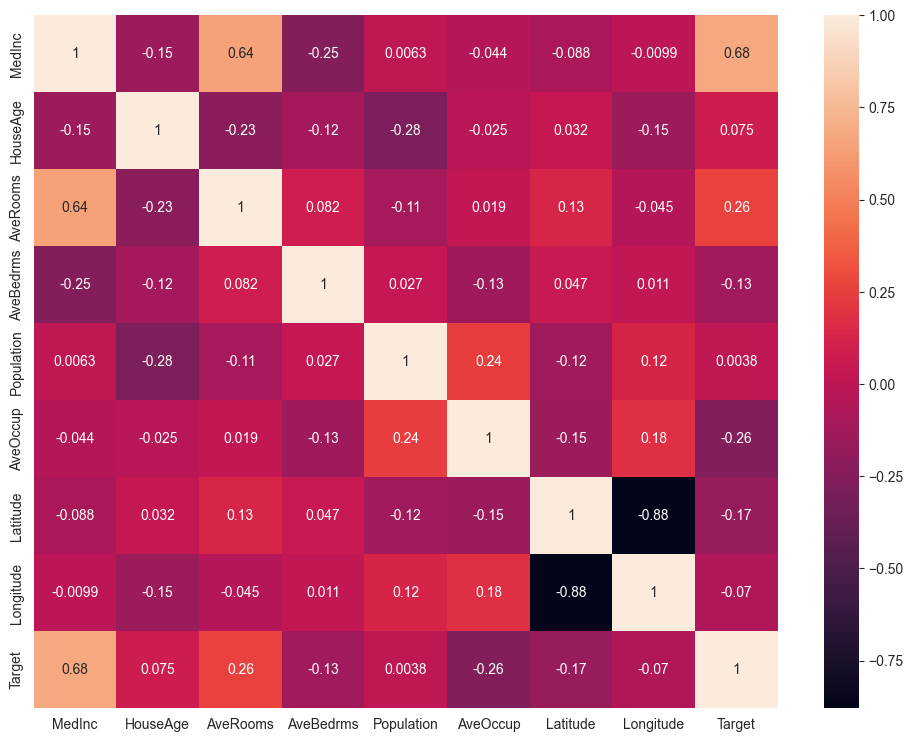

In [1749]:
#Посмотрим на зависимость переменных
#Поскольку данные не имеют нормального распределения для подсчета корреляции будем использовать ранговый тест Спирмена.
sns.heatmap(pd.concat([X, pd.Series(y, name="Target")], axis=1).corr(method="spearman"), annot=True);
#Можно заметить, что таргетная переменная имеет наибольшую корреляцию с переменной MedInc

In [1750]:
#Разделим данные на тестовую и тренировочную выборки
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25,
                                                    random_state=SEED)

In [1751]:
#Сделаем пайплайн (стандартизация данных и создание модели)
model_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

In [1752]:
#Обучим модель 
model_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [1753]:
#Предскажем значения
predictions = model_pipe.predict(X_test)

In [1754]:
#Проверим качество модели с помощью метрик
print(f"MSE: {mean_squared_error(y_test, predictions)}")
print(f"R2 = {r2_score(y_test, predictions)}")

MSE: 0.5351866874069421
R2 = 0.6021374561427344


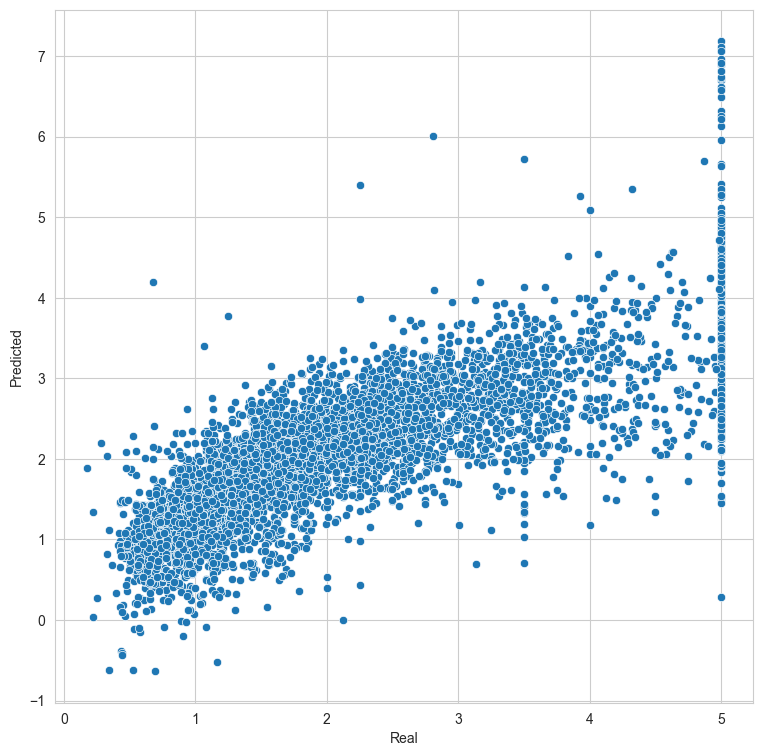

In [1755]:
#Визуализируем
df = pd.DataFrame()
df['Real'] = pd.Series(y_test)
df['Predicted'] = pd.Series(predictions)
figure = plt.figure(figsize=(9, 9))
axes = sns.scatterplot(data=df, x='Real', y='Predicted', legend=False)

Попробуем улучшить модель за счет удаления выбросов из данных

In [1756]:
#Найдем индексы выбросов
outliers_averooms = pd.Series(np.where(X['AveRooms'] > 100)[0])
outliers_population = pd.Series(np.where(X['Population'] > 25000)[0])
outliers_aveoccup = pd.Series(np.where(X['AveOccup'] > 800)[0])
outliers = pd.concat([outliers_averooms, outliers_population, outliers_aveoccup])

In [1757]:
#Удалим выбросы
X_no_outliers = X.drop(outliers)
y_no_outliers = pd.Series(y).drop(outliers)

In [1758]:
#Разделим данные без выбросов на тестовую и тренировочную выборки 
X_train_filt, X_test_filt, y_train_filt, y_test_filt = train_test_split(X_no_outliers, 
                                                    y_no_outliers, 
                                                    test_size=0.25,
                                                    random_state=SEED)

In [1759]:
#Сделаем пайплайн (стандартизация данных и создание модели)
model_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])
#Обучим модель 
model_pipe.fit(X_train_filt, y_train_filt)
#Предскажем значения
predictions_filt = model_pipe.predict(X_test_filt)
#Проверим качество модели с помощью метрик
print(f"MSE: {mean_squared_error(y_test_filt, predictions_filt)}")
print(f"R2 = {r2_score(y_test_filt, predictions_filt)}")

MSE: 0.5287897077423834
R2 = 0.600629060160137


Удаление выбросов не повлияло на качество модели (по метрикам), однако если посмотреть на график (ниже) он выглядит так себе

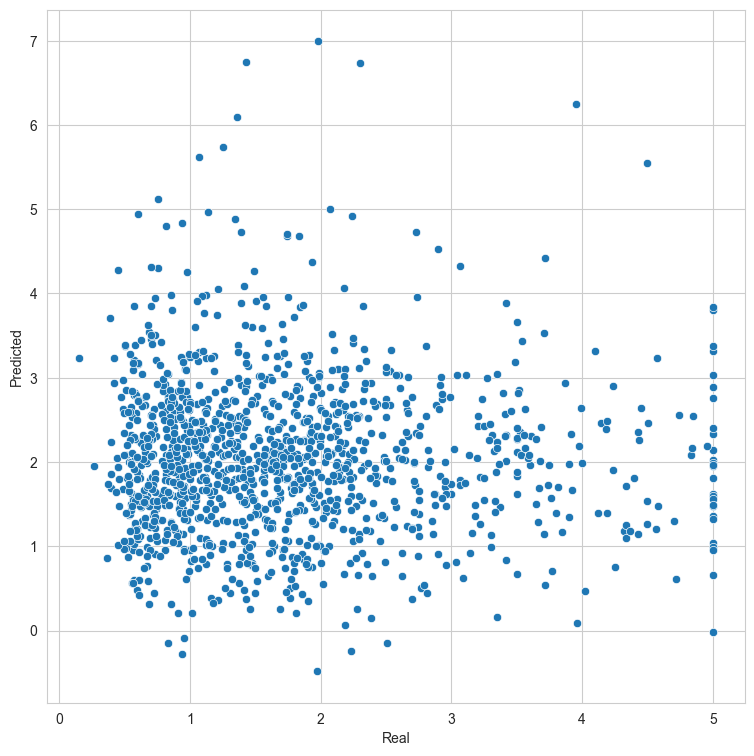

In [1760]:
#Визуализируем
df = pd.DataFrame()
df['Real'] = pd.Series(y_test_filt)
df['Predicted'] = pd.Series(predictions_filt)
figure = plt.figure(figsize=(9, 9))
axes = sns.scatterplot(data=df, x='Real', y='Predicted', legend=False)

### Задание 3. Реализация логистической регресии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справить с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуйте функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [1761]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)
    
    return 1 / (1 + np.e**(- output))


#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

In [1762]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    return -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1-y_pred)) / np.size(y_pred)
    

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return X.T @ (y_pred - y_true)

class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуйте метод `predict` у класса `CustomLogisticRegression`, не забудьте про свободный член!

In [1763]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        return sigmoid(np.matmul(X_test, self.W))
    
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [1764]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

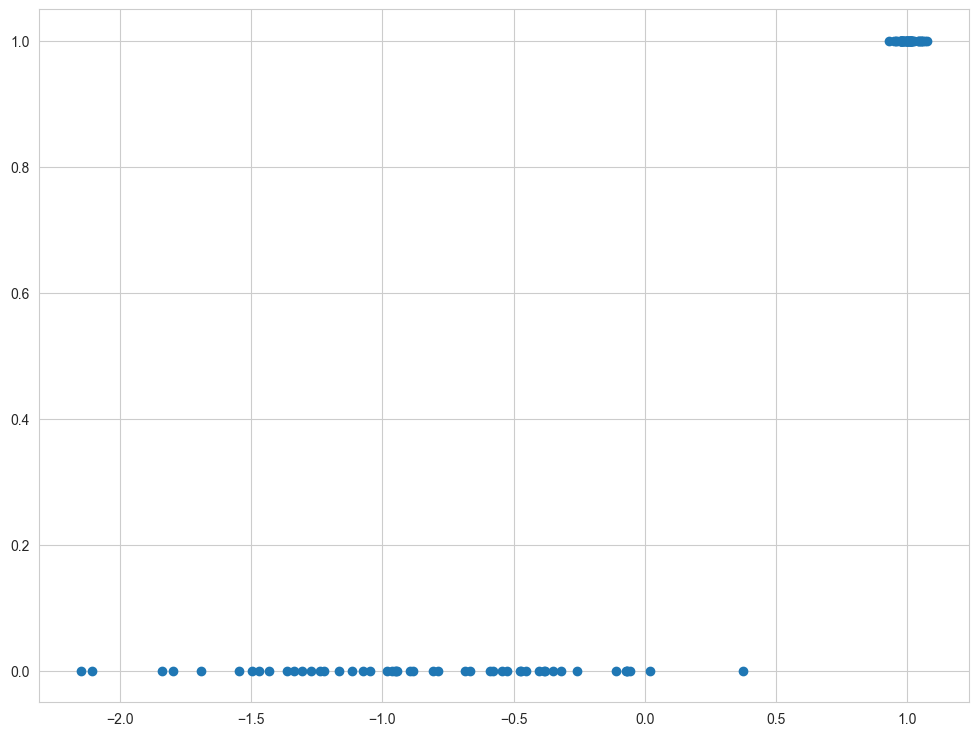

In [1765]:
plt.scatter(X, y);

In [1766]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

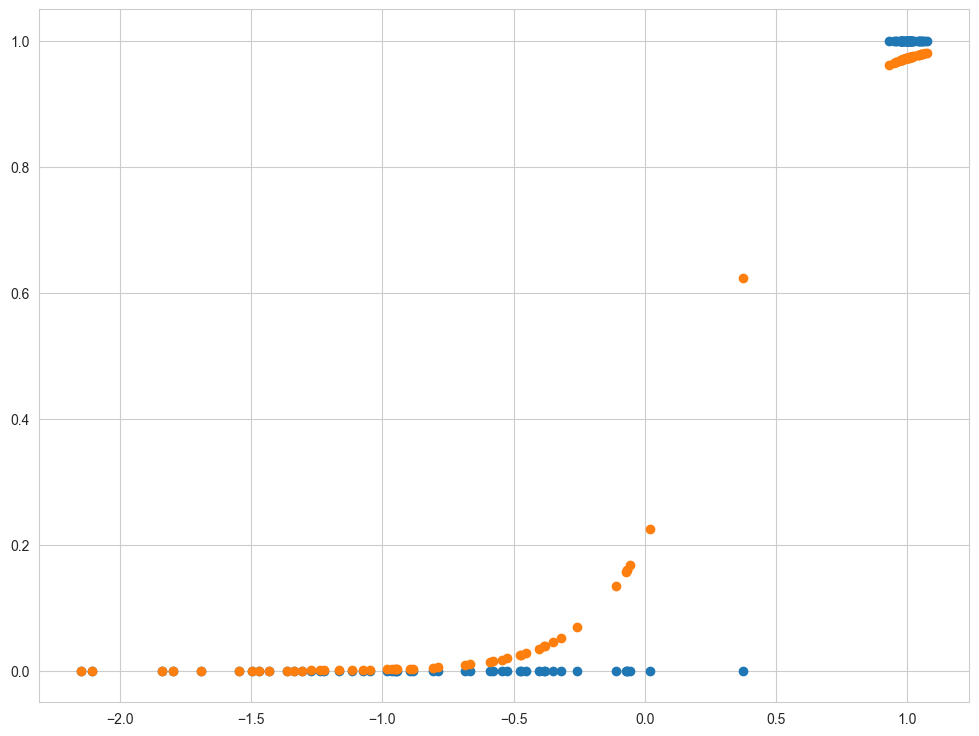

In [1767]:
plt.scatter(X, y)
plt.scatter(X, y_pred);

Проверьте качество работы модели при помощи известных вам метрик бинарной классификации.

In [1768]:
print(f"ROC AUC: {roc_auc_score(y,y_pred)}") 
print(f"BCE: {bce(y, y_pred)}")

#Также посчитаем такие метрики как Accuracy, Precision, Recall и F1_score. Для этого для начала переведем полученные предсказанные вероятности в значения класса 0 и 1 (возьмем порог 0,5).

y_pred_category = np.where(y_pred > 0.5, 1, 0)

print(f"Accuracy =  {accuracy_score(y, y_pred_category)}")
print(f"Precision = {precision_score(y,y_pred_category)}")
print(f"Recall = {recall_score(y,y_pred_category)}")
print(f"F1_score = {f1_score(y,y_pred_category)}")
#Метрики показывают высокие значения, что может говорить о том, что модель хорошо предсказывает классы

ROC AUC: 1.0
BCE: 232.08074834464568
Accuracy =  0.99
Precision = 0.9803921568627451
Recall = 1.0
F1_score = 0.9900990099009901


#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам покемонов (https://www.kaggle.com/abcsds/pokemon). В данном задании вам необходимо сначала сделать краткий EDA (Посмотреть на данные и их распределения, а также посмотреть, как различные признаки связаны между собой и с целевой переменной (`Legendary`)).

In [1769]:
pokemon = pd.read_csv("../Data/Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

In [1770]:
#Посмотрим на тип данных переменных
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [1771]:
pokemon.describe()

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,362.813750,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,208.343798,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.000000,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,184.750000,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,364.500000,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,539.250000,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,721.000000,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


Name: Name of each pokemon
Type 1: Each pokemon has a type, this determines weakness/resistance to attacks
Type 2: Some pokemon are dual type and have 2
Total: sum of all stats that come after this, a general guide to how strong a pokemon is
HP: hit points, or health, defines how much damage a pokemon can withstand before fainting
Attack: the base modifier for normal attacks (eg. Scratch, Punch)
Defense: the base damage resistance against normal attacks
SP Atk: special attack, the base modifier for special attacks (e.g. fire blast, bubble beam)
SP Def: the base damage resistance against special attacks
Speed: determines which pokemon attacks first each round
generation: The numbered generation which the Pokemon was first introduced
is_legendary: Denotes if the Pokemon is legendary.

In [1772]:
#Похоже, что колонка Generation категориальная, проверим количество уникальных значений
print (f"Количество уникальных значений в колонке Generation: {len(pokemon.Generation.unique())}")
#Проверим количество уникальных значений в колонках с типом
print(f'Количество уникальных классов в колонке Type 1: {len(pokemon["Type 1"].unique())}')
print(f'Количество уникальных классов в колонке Type 2: {len(pokemon["Type 2"].unique())}')
#Переведем целевую колонку в 0 и 1
pokemon.Legendary = pokemon.Legendary.astype('int')

Количество уникальных значений в колонке Generation: 6
Количество уникальных классов в колонке Type 1: 18
Количество уникальных классов в колонке Type 2: 19


In [1773]:
#Посмотрим на баланс классов внутри целевой переменной
pokemon.Legendary.value_counts()
#Кажется есть большие проблемы с балансом. 0 намного больше чем 1

Legendary
0    735
1     65
Name: count, dtype: int64

In [1774]:
#Посмотрим на количество выбросов 
pokemon.isna().sum()
#Переменная type 2 имеет около половины пропусков, поэтому не будем использовать ее в анализе. Нет смысла ради сохранения одной переменной убирать половину данных.
pokemon = pokemon.drop(['Type 2', 'Name', '#'], axis=1)

In [1775]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Type 1      800 non-null    object
 1   Total       800 non-null    int64 
 2   HP          800 non-null    int64 
 3   Attack      800 non-null    int64 
 4   Defense     800 non-null    int64 
 5   Sp. Atk     800 non-null    int64 
 6   Sp. Def     800 non-null    int64 
 7   Speed       800 non-null    int64 
 8   Generation  800 non-null    int64 
 9   Legendary   800 non-null    int64 
dtypes: int64(9), object(1)
memory usage: 62.6+ KB


In [1776]:
#Для выбора правильного теста корреляции проверим данные на нормальность распределения с использованием теста Шапиро-Уилка
num_columns = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Legendary']
for col in num_columns:
  print(f"{col} - {stats.shapiro(pokemon[col])}")
# p-value везде меньше 0.01, поэтому на уровне значимости 1% 
# гипотеза о нормальности отвергается для всех числовых колонок

Total - ShapiroResult(statistic=0.9817469931204351, pvalue=1.93257335314653e-08)
HP - ShapiroResult(statistic=0.9158320940777537, pvalue=1.1523642181572454e-20)
Attack - ShapiroResult(statistic=0.9789300914531911, pvalue=2.4721544454875703e-09)
Defense - ShapiroResult(statistic=0.9380627974921573, pvalue=9.923171943899816e-18)
Sp. Atk - ShapiroResult(statistic=0.9595379665844156, pvalue=4.665141004586872e-14)
Sp. Def - ShapiroResult(statistic=0.9607658547869564, pvalue=8.25179100814156e-14)
Speed - ShapiroResult(statistic=0.9841601747324947, pvalue=1.309542171314861e-07)
Legendary - ShapiroResult(statistic=0.3029570018570892, pvalue=1.5769373719752776e-47)


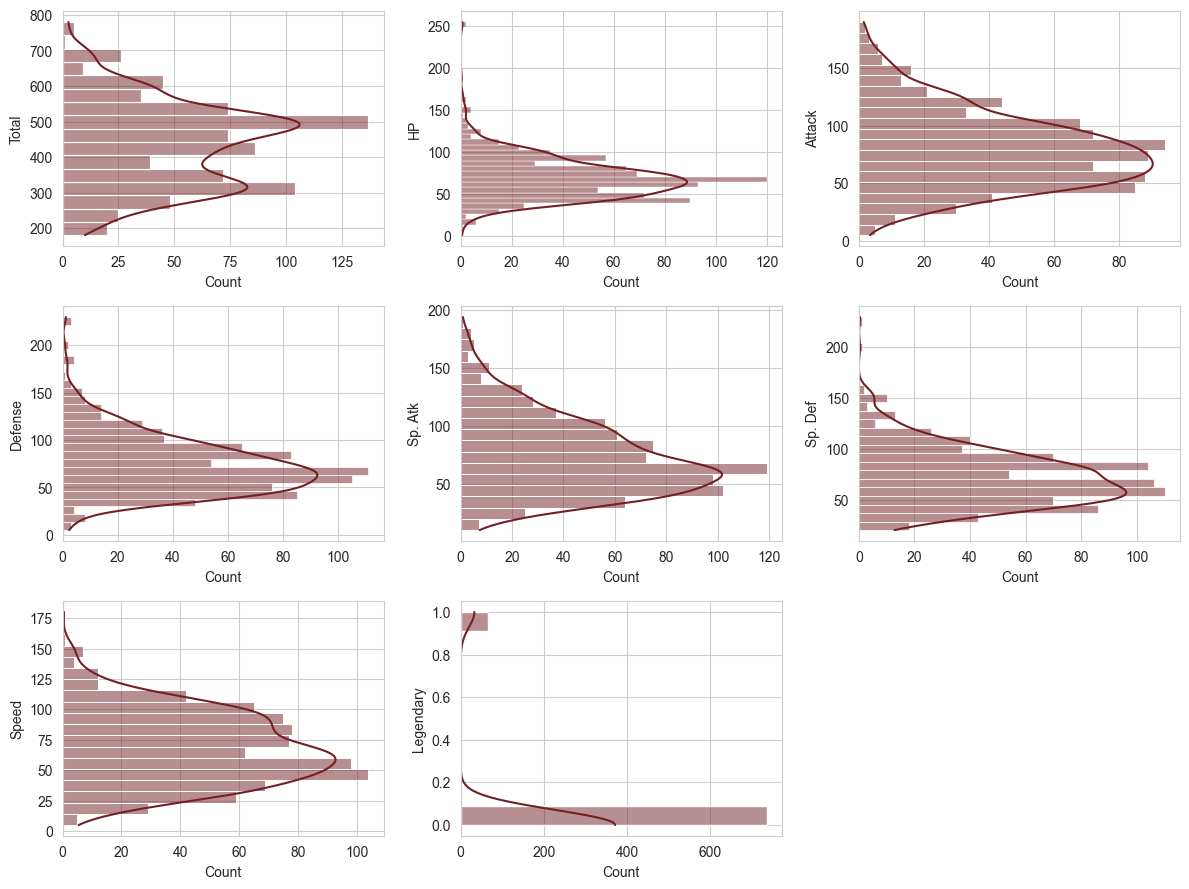

In [1777]:
i = 1
for col in pokemon[num_columns]:
  plt.subplot(3, 3, i)
  sns.histplot(y=pokemon[col], color = '#732023',kde=True, )
  i += 1

plt.tight_layout();

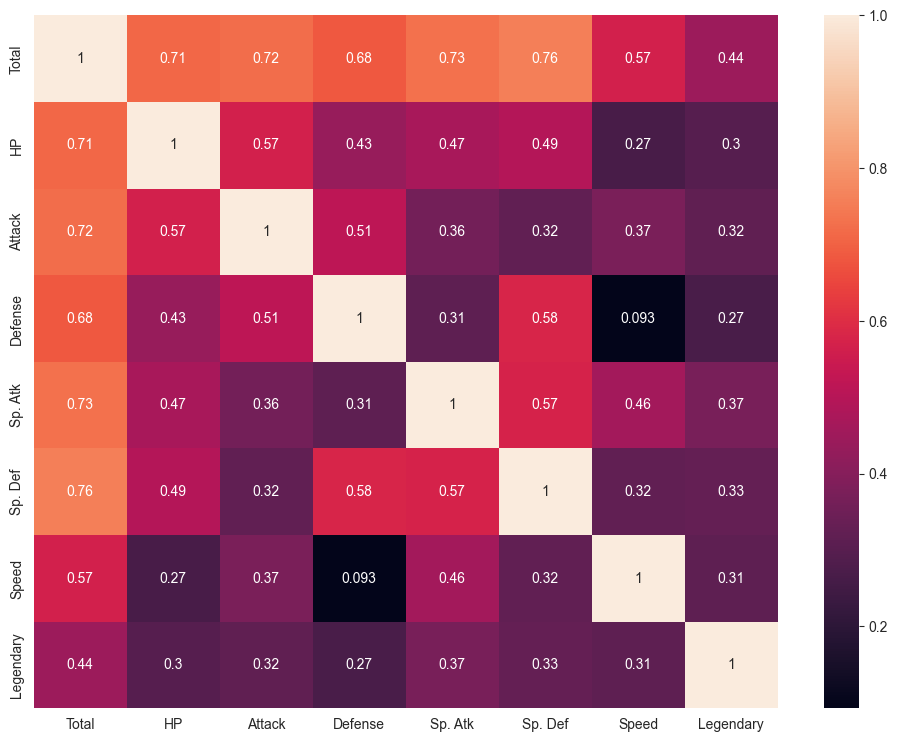

In [1778]:
#Посмотрим на взаимосвязь переменных с использованием корреляции Спирмена
sns.heatmap(pokemon[num_columns].corr(method="spearman"), annot=True);

In [1779]:
#Сделаем трансформатор для данных
category_columns = ['Type 1','Generation']
X = pokemon.iloc[:, :-1]
y = pokemon.Legendary.to_numpy()
#Будем использовать OneHotEncoder для категориальных столбцов и StandardScaler для числовых
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_columns[:-1]),
    ("ohe", OneHotEncoder(), category_columns)
])

In [1780]:
preprocessor

ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                 ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk',
                                  'Sp. Def', 'Speed']),
                                ('ohe', OneHotEncoder(),
                                 ['Type 1', 'Generation'])])

In [1781]:
#Создадим пайплайн
model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression())
])

Разделите ваши данные на тестовую и тренировочную выборку.

In [1782]:
#Разделим данные на тестовую и тренировочную выборки
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.30,
                                                    random_state=SEED, stratify=y)

Обучите модель `LogisticRegression` из `sklearn`.

In [1783]:
#Обучим модель и предскажем значения
model_pipeline.fit(X_train, y_train)
predictions_proba = model_pipeline.predict_proba(X_test)
predictions = model_pipeline.predict(X_test)

Выведите метрики вашего классификатора:

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

In [1784]:
print(f"Accuracy =  {accuracy_score(y_test, predictions)}")
print(f"Precision = {precision_score(y_test,predictions)}")
print(f"Recall = {recall_score(y_test,predictions)}")
print(f"F1_score = {f1_score(y_test,predictions)}")

Accuracy =  0.9333333333333333
Precision = 0.6153846153846154
Recall = 0.42105263157894735
F1_score = 0.5


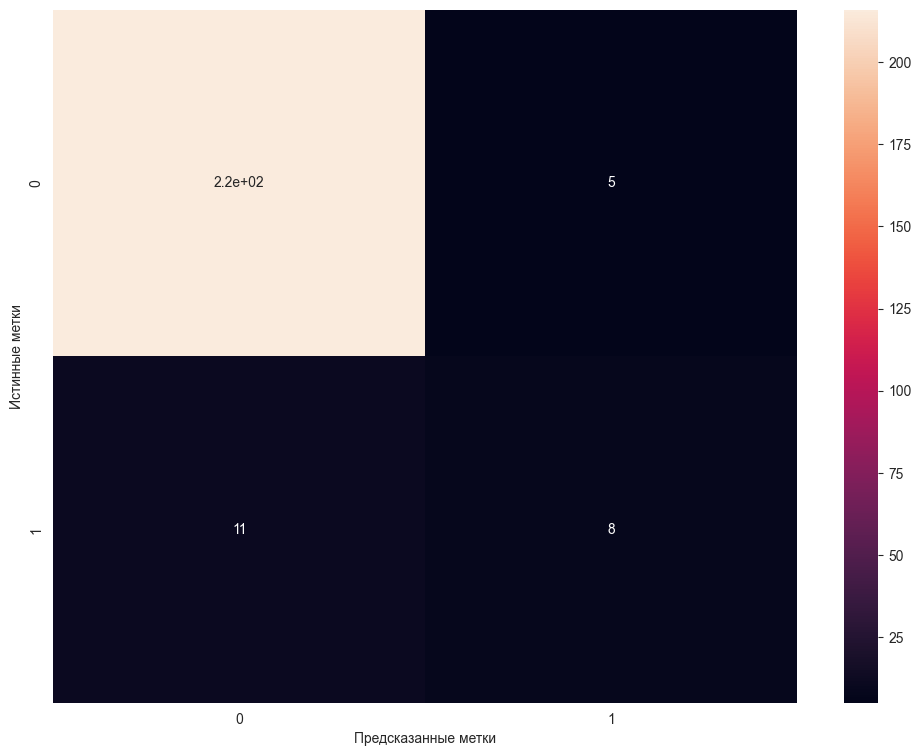

In [1785]:
sns.heatmap(confusion_matrix(y_test, predictions),
            annot=True).set(xlabel="Предсказанные метки", ylabel="Истинные метки");

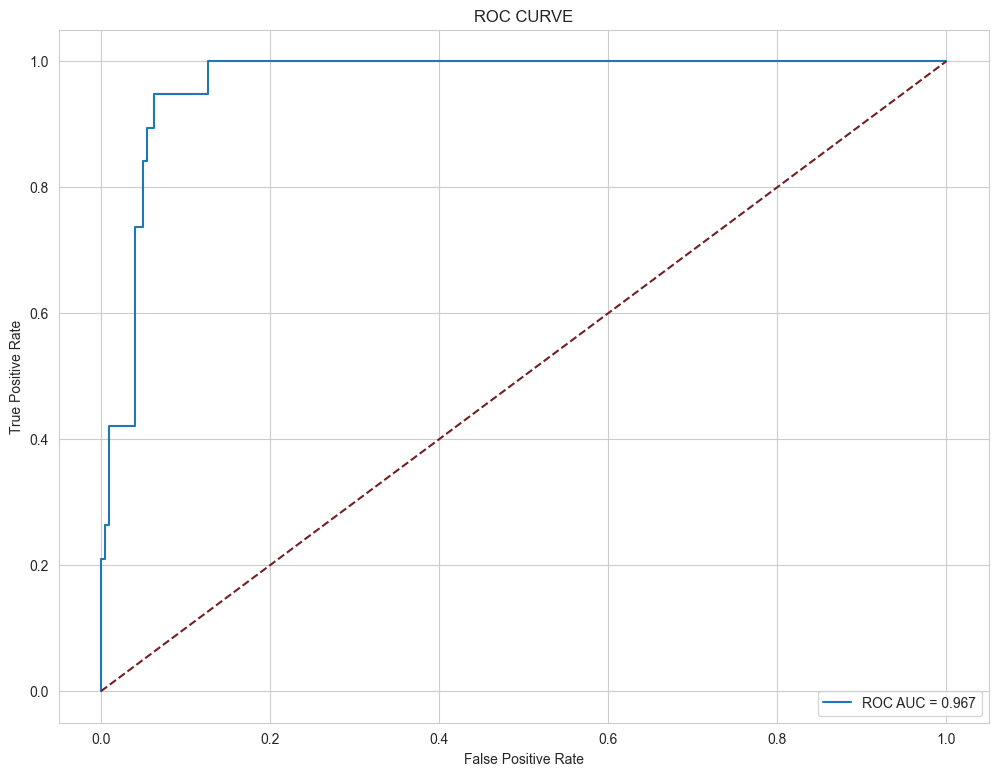

In [1786]:
#Построим ROC кривую
fpr, tpr, thresholds = roc_curve(y_test, predictions_proba[:, 1])
plt.plot(fpr, tpr, label = f"ROC AUC = {round(roc_auc_score(y_test, predictions_proba[:, 1]),3)}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CURVE")
plt.plot([0, 1], [0, 1], color= '#732023', linestyle='--')
plt.legend(loc="lower right");

Модель хорошо предсказывает 0 класс, при этом она делает ошибки в предсказании 1 класса (FN = 11). Данный факт вероятно связан с тем, что в наших данных наблюдается дисбаланс классов и 0 класс преобладает. Это также видно по снижению метрики Recall.

In [1787]:
#Для того, чтобы определить важность признаков, посмотрим на коэффициенты:
reg_model = model_pipeline.named_steps['model']

for feature, coef in zip(X.columns,reg_model.coef_[0]):
    print(f"{feature}: {coef}")

#важными признаками являются: Type 1, Total, Sp. Def

Type 1: 1.1627170881491455
Total: 0.9355497797955219
HP: 0.26827313274106446
Attack: 0.7268402978955332
Defense: 0.7025580680361101
Sp. Atk: 0.999647926981197
Sp. Def: 1.1315200234420966
Speed: -0.5555642472354796
Generation: -0.17531843424951138


In [1788]:
pokemon = pd.read_csv("../Data/Pokemon.csv")

In [1789]:
pokemon = pokemon.drop(['Type 2', 'Name', '#','Generation', 'Type 1'], axis=1)
#Переведем целевую колонку в 0 и 1
pokemon.Legendary = pokemon.Legendary.astype('int')
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Total      800 non-null    int64
 1   HP         800 non-null    int64
 2   Attack     800 non-null    int64
 3   Defense    800 non-null    int64
 4   Sp. Atk    800 non-null    int64
 5   Sp. Def    800 non-null    int64
 6   Speed      800 non-null    int64
 7   Legendary  800 non-null    int64
dtypes: int64(8)
memory usage: 50.1 KB


In [1790]:
#Сделаем пайплайн
X = pokemon.iloc[:, :-1]
y = pokemon.Legendary.to_numpy()
model_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

In [1791]:
#Разделим данные на тестовые и обучающие
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.30,
                                                    random_state=SEED, stratify=y)

In [1792]:
#Обучим модель и предскажем значения
model_pipeline.fit(X_train, y_train)
predictions_proba = model_pipeline.predict_proba(X_test)
predictions = model_pipeline.predict(X_test)

In [1793]:
print(f"Accuracy =  {accuracy_score(y_test, predictions)}")
print(f"Precision = {precision_score(y_test,predictions)}")
print(f"Recall = {recall_score(y_test,predictions)}")
print(f"F1_score = {f1_score(y_test,predictions)}")

Accuracy =  0.9291666666666667
Precision = 0.5714285714285714
Recall = 0.42105263157894735
F1_score = 0.48484848484848486


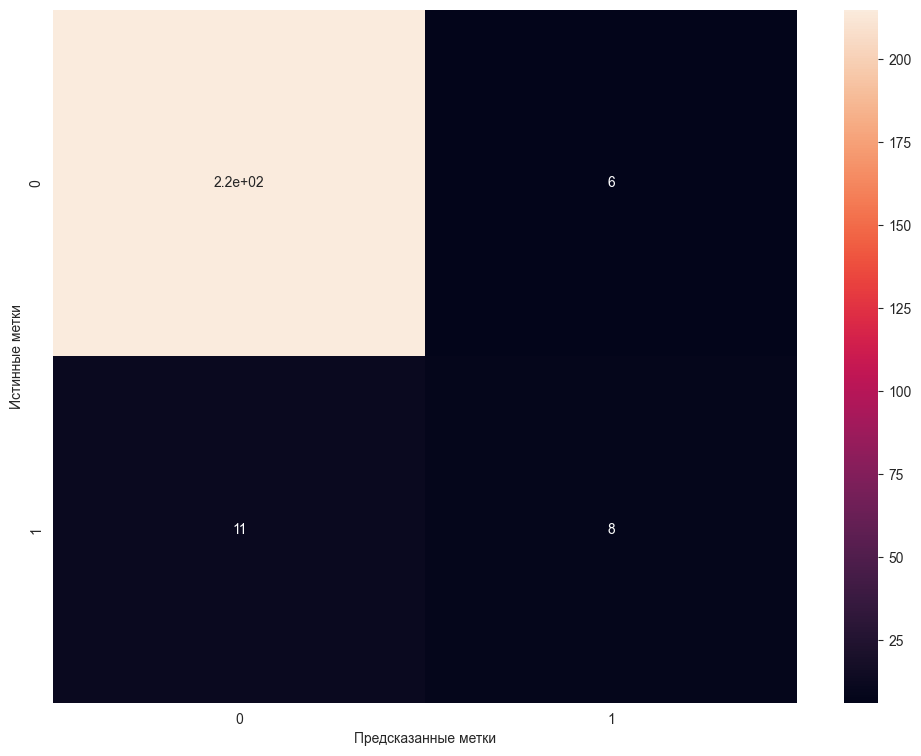

In [1794]:
sns.heatmap(confusion_matrix(y_test, predictions),
            annot=True).set(xlabel="Предсказанные метки", ylabel="Истинные метки");

Модель хорошо предсказывает 0 класс, при этом она делает ошибки в предсказании 1 класса (FN = 11). Данный факт вероятно связан с тем, что в наших данных наблюдается дисбаланс классов и 0 класс преобладает. Это также видно по снижению метрики Recall.

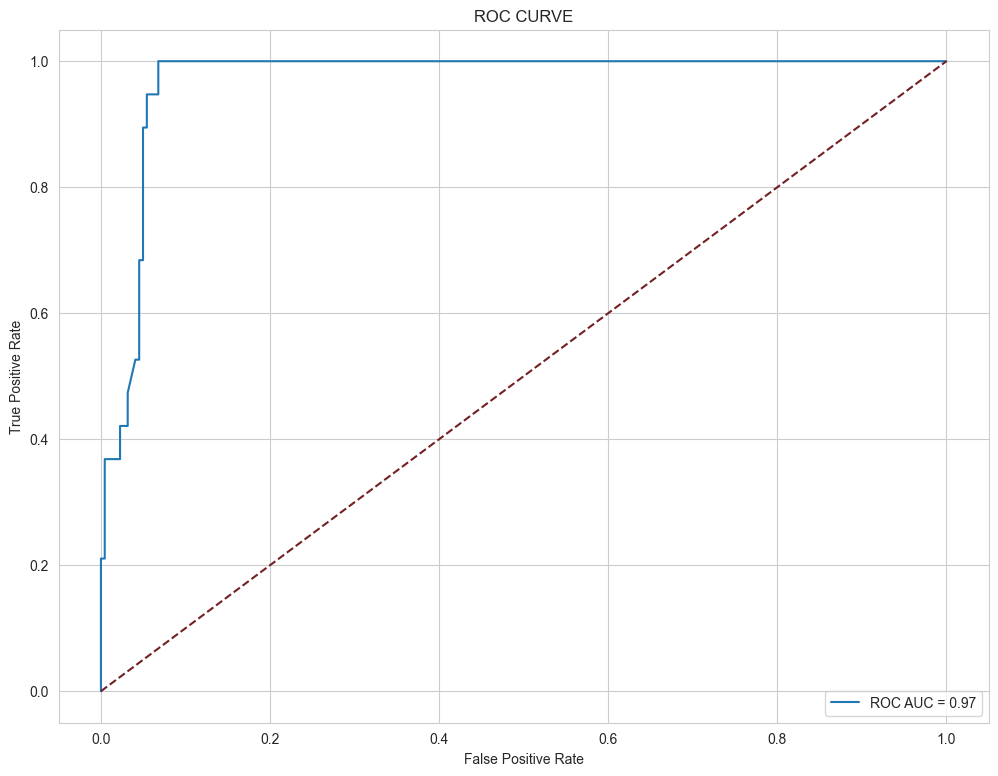

In [1795]:
#Построим ROC кривую
fpr, tpr, thresholds = roc_curve(y_test, predictions_proba[:, 1])
plt.plot(fpr, tpr, label = f"ROC AUC = {round(roc_auc_score(y_test, predictions_proba[:, 1]),3)}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CURVE")
plt.plot([0, 1], [0, 1], color= '#732023', linestyle='--')
plt.legend(loc="lower right");

In [1796]:
#Для того, чтобы определить важность признака, посмотрим на коэффициенты:
reg_model = model_pipeline.named_steps['model']

for feature, coef in zip(X.columns,reg_model.coef_[0]):
    print(f"{feature}: {coef}")


Total: 1.1119728858477227
HP: 0.7635594867573376
Attack: 0.2842761774902916
Defense: 0.6580388638333511
Sp. Atk: 0.8132661618786867
Sp. Def: 1.00812304604103
Speed: 0.9914252244598707


Наиболее важными признаками оказались: Total, Speed, Sp. Def

### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Расскажите, как вы познакомились с этой группой и скиньте несколько наиболее любимых треков)

У меня нет любимых групп или исполнителей. Но в целом, мне нравится Imagine Dragons, Skillet и инструментальная музыка:
https://music.yandex.ru/album/3015939/track/19641303
https://music.yandex.ru/album/7643774/track/27941553
https://music.yandex.ru/album/2531875/track/21998033

 

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:** 